/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3124: RuntimeWarning: invalid value encountered in cos
  dlat = dc.imag * np.cos(np.radians(lats))
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3128: RuntimeWarning: invalid value encountered in greater_equal
  farnorth = np.abs(lats+dlat) >= 90.0
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3140: RuntimeWarning: invalid value encountered in subtract
  vecangle = np.arctan2(yn-y, xn-x)


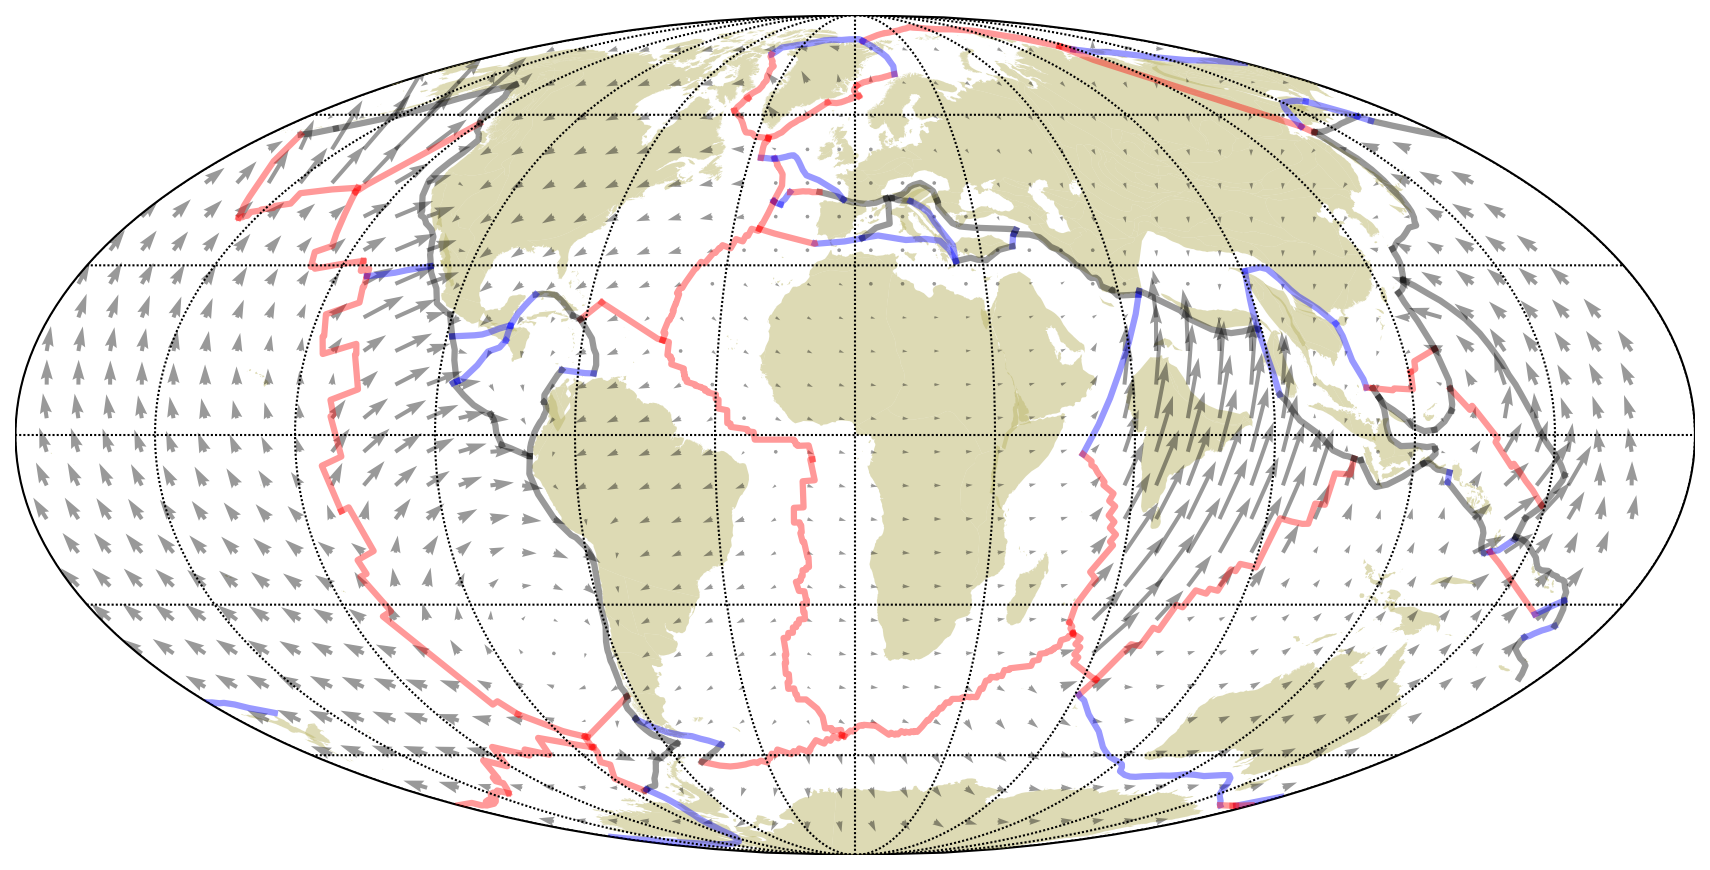

In [1]:
import pygplates
import numpy as np
import sys
sys.path.append('../libs/')
from topology_plotting import *
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
from matplotlib.patches import Polygon

%matplotlib inline

rotation_filename = 'Data/Global_EarthByte_230-0Ma_GK07_AREPS.rot'
topology_features = ['Data/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpmlz',\
             'Data/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpmlz']

# Load one or more rotation files into a rotation model.
rotation_model = pygplates.RotationModel(rotation_filename)

time=50

coastlines_file = 'Data/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpmlz'
pygplates.reconstruct(coastlines_file, rotation_model, '/tmp/tmp.shp', time, 1)

fig = plt.figure(figsize=(14,10),dpi=150)
ax_map = fig.add_axes([0,0,0.8,1.0])
lon0=0
m = Basemap(projection='moll', lon_0=lon0, resolution='c', ax=ax_map)
#m = Basemap(resolution='c',projection='ortho',lat_0=30.,lon_0=lon0)
cp = m.drawmapboundary()
#m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30))
m.drawmeridians(np.arange(-180,180,30))

# Plot reconstructed coastlines
shp_info = m.readshapefile('/tmp/tmp','shp',drawbounds=True,color='none')
for nshape,seg in enumerate(m.shp):
    poly = Polygon(seg,facecolor='DarkKhaki',edgecolor='none',alpha=0.5,zorder=0)
    plt.gca().add_patch(poly)
        
plot_velocities_and_topologies(m,topology_features,rotation_model,time,
                               delta_time=5,res=10,scale=4000,lon0=lon0,clip_path=cp)

plt.show()


In [2]:
%%capture capt --no-stdout
time_step = 2.
oldest_seed_time = 10.

# Empty array for storing Long/Lat of 
point_longitude = []
point_latitude = []


# Location of seed point for Kerguelen
hs_geometry = []
# Seed point for Kerguelen
hs_geometry.append(pygplates.PointOnSphere(-49, 69))
# Seed point for Hawaii
hs_geometry.append(pygplates.PointOnSphere(19, -155))
# Seed point for Reunion
hs_geometry.append(pygplates.PointOnSphere(-17, 59))
# Seed point for Iceland
hs_geometry.append(pygplates.PointOnSphere(64, -17))
# Seed point for Tristan
hs_geometry.append(pygplates.PointOnSphere(-37, -12))
# Seed point for Louisville
hs_geometry.append(pygplates.PointOnSphere(-54, -141))
# Seed point for Afar
hs_geometry.append(pygplates.PointOnSphere(7, 39))
# Seed point for Samoa
hs_geometry.append(pygplates.PointOnSphere(-15, -168))
# Seed point for Easter
hs_geometry.append(pygplates.PointOnSphere(-27, -110))
# Seed point for Crozet
hs_geometry.append(pygplates.PointOnSphere(-46, 50))
# Seed point for Ascension
hs_geometry.append(pygplates.PointOnSphere(-8, -14))
# Seed point for Tahiti
hs_geometry.append(pygplates.PointOnSphere(-18, -148))
# Seed point for Azores
hs_geometry.append(pygplates.PointOnSphere(38, -28))
# Seed point for Yellowstone
hs_geometry.append(pygplates.PointOnSphere(44, -111))
  
point_list = []

for time in np.arange(oldest_seed_time,0.,-time_step):
    
    print(f'working on time {time}')
    
    for hs_point in hs_geometry:
        point_list.append(hs_point)    

    # Get the plate polygons for this time
    resolved_topologies = []
    shared_boundary_sections = []
    pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)

    # make plate partitioner from polygons
    plate_partitioner = pygplates.PlatePartitioner(resolved_topologies, rotation_model)

    new_point_list = []
    point_longitude = []
    point_latitude = []
    for seed_geometry in point_list:
    # Find the plate id of the polygon that contains the point
        polygon = plate_partitioner.partition_point(seed_geometry)
    
        PlateID = polygon.get_feature().get_reconstruction_plate_id()
        #print PlateID

        # Get the stage rotation that will move the point from where it is at the current time
        # to its location at the next time step, based on the plate id that contains the point at the 
        # current time
        stage_rotation = rotation_model.get_rotation(time-time_step, PlateID, time, anchor_plate_id=1)

        # use the stage rotation to reconstruct the tracked point from position at current time 
        # to position at the next time step
        seed_geometry = stage_rotation * seed_geometry
    
        point_longitude.append(seed_geometry.to_lat_lon_point().get_longitude())
        point_latitude.append(seed_geometry.to_lat_lon_point().get_latitude())
        
        new_point_list.append(seed_geometry)
        
    point_list = new_point_list
        
    #### Plotting
    pygplates.reconstruct(coastlines_file, rotation_model, '/tmp/tmp.shp', time, 1)

    fig = plt.figure(figsize=(14,10),dpi=150)
    ax_map = fig.add_axes([0,0,0.8,1.0])
    lon0=0
    m = Basemap(projection='moll', lon_0=lon0, resolution='c', ax=ax_map)
    #m = Basemap(resolution='c',projection='ortho',lat_0=30.,lon_0=lon0)
    cp = m.drawmapboundary()
    m.drawparallels(np.arange(-90,90,30))
    m.drawmeridians(np.arange(-180,180,30))

    # Plot reconstructed coastlines
    shp_info = m.readshapefile('/tmp/tmp','shp',drawbounds=True,color='none')
    for nshape,seg in enumerate(m.shp):
        poly = Polygon(seg,facecolor='DarkKhaki',edgecolor='none',alpha=0.5,zorder=0)
        plt.gca().add_patch(poly)

    plot_velocities_and_topologies(m,topology_features,rotation_model,time,
                                   delta_time=5,res=10,scale=4000,lon0=lon0,clip_path=cp)
    
    for hs_point in hs_geometry:
        x,y = m(hs_point.to_lat_lon()[1],hs_point.to_lat_lon()[0])
        m.plot(x,y,'r*',markersize=20,zorder=1)
    
    x, y = m(point_longitude, point_latitude)
    m.plot(x,y,'.',markersize=10,zorder=1)
    
    plt.title('Time = %d Ma' % time)

    plt.savefig('/tmp/plume_product_tracker_%d_Ma.png' % time)
    plt.close()
    
    

working on time 10.0
working on time 8.0
working on time 6.0
working on time 4.0
working on time 2.0


If moviepy is available, you can try creating a gif (or other animation format) from the sequence of images generated in the above cell.

In [3]:
import moviepy.editor as mpy

frame_list = []

for time in np.arange(oldest_seed_time,0.,-time_step):
    frame_list.append('/tmp/plume_product_tracker_%d_Ma.png' % time)
    

clip = mpy.ImageSequenceClip(frame_list, fps=5)
clip.write_gif('/tmp/hotspot_trails.gif')

t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]

MoviePy - Building file /tmp/hotspot_trails.gif with imageio.


The movie will show up in a few seconds. Please be patient...


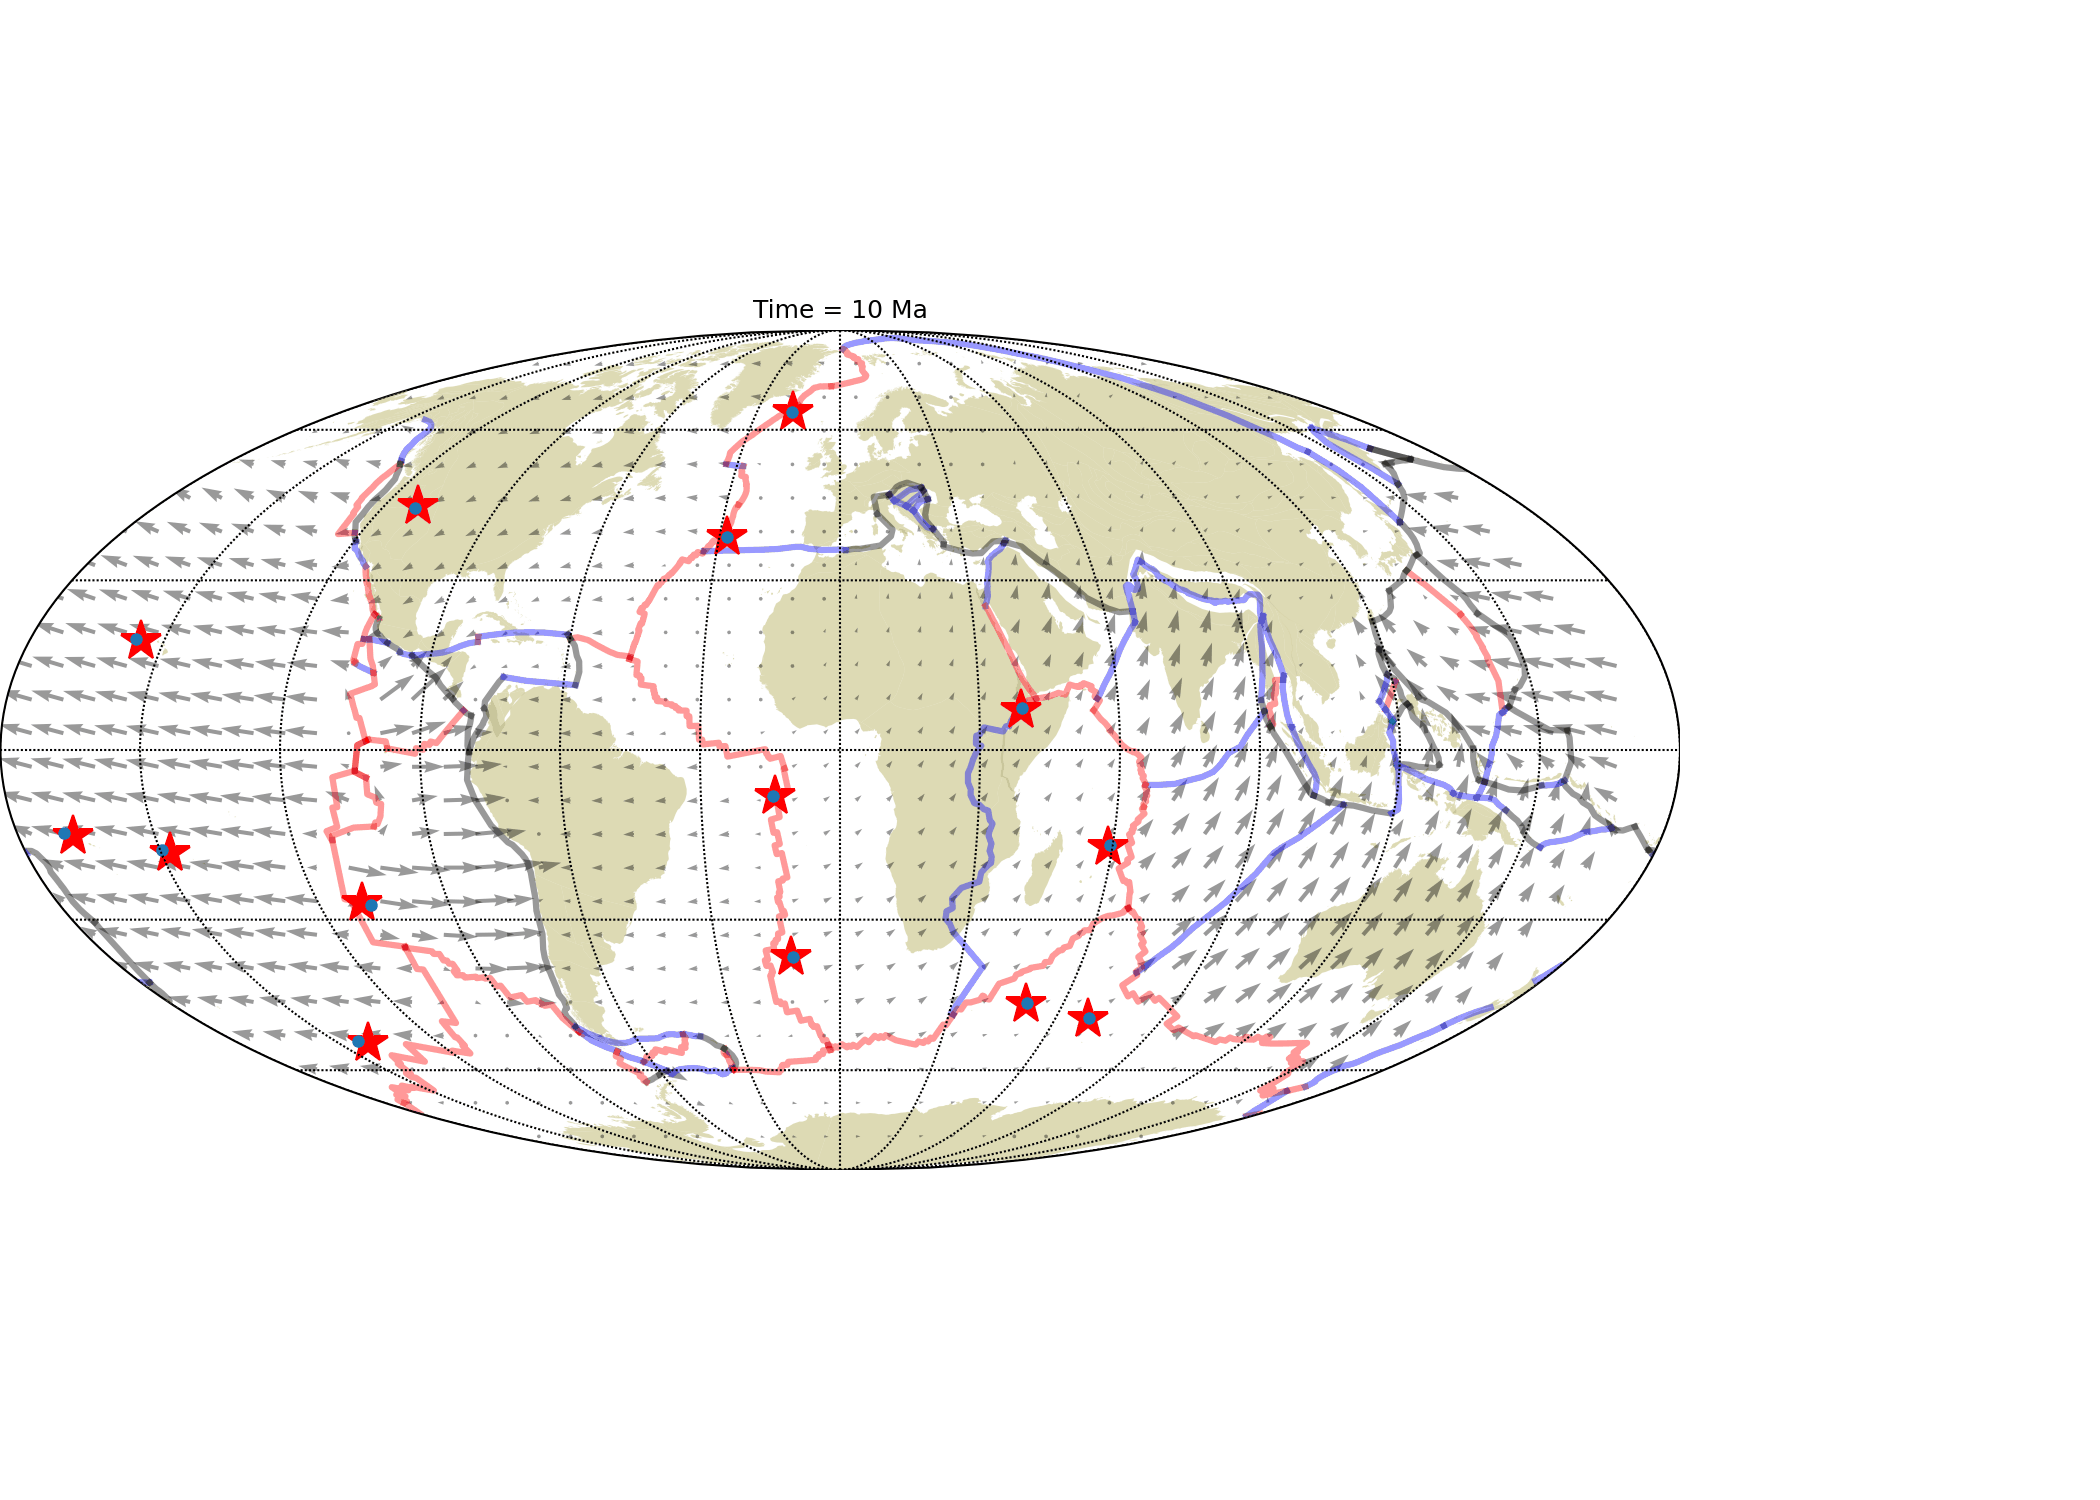

In [4]:
from IPython.display import Image
print('The movie will show up in a few seconds. Please be patient...')
with open('/tmp/hotspot_trails.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

In [5]:
print('done')

done
